In [2]:
import numpy as np
import pandas as pd
import gc
import pickle
import time

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
data = pd.read_pickle('matrix.pickle')
X_train = data[data.date_block_num < 33].drop(['date_block_num','item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['date_block_num','item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['date_block_num','item_cnt_month'], axis=1)
del data
gc.collect();

In [4]:
ts = time.time()

m1 = XGBRegressor(
    max_depth=15,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    colsample_bylevel=0.8, 
    subsample=0.8, 
    eta=0.3, 
    num_round=1000,
    seed=1, 
    nthread=24)

m1.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.14212	validation_1-rmse:1.10874
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08801	validation_1-rmse:1.0729
[2]	validation_0-rmse:1.04132	validation_1-rmse:1.03765
[3]	validation_0-rmse:0.998545	validation_1-rmse:1.00791
[4]	validation_0-rmse:0.962258	validation_1-rmse:0.989012
[5]	validation_0-rmse:0.930361	validation_1-rmse:0.969599
[6]	validation_0-rmse:0.903469	validation_1-rmse:0.952982
[7]	validation_0-rmse:0.881119	validation_1-rmse:0.940115
[8]	validation_0-rmse:0.861829	validation_1-rmse:0.928694
[9]	validation_0-rmse:0.845465	validation_1-rmse:0.920217
[10]	validation_0-rmse:0.831149	validation_1-rmse:0.915283
[11]	validation_0-rmse:0.818242	validation_1-rmse:0.910227
[12]	validation_0-rmse:0.807474	validation_1-rmse:0.905426
[13]	validation_0-rmse:0.799343	validation_1-rmse:0.902398
[14]	validation_0-rmse:0.79143	va

20420.484486103058

In [7]:
pickle.dump(m1, open("m1.pickle.dat", "wb"))
#m1 = pickle.load(open("m1.pickle.dat", "rb"))

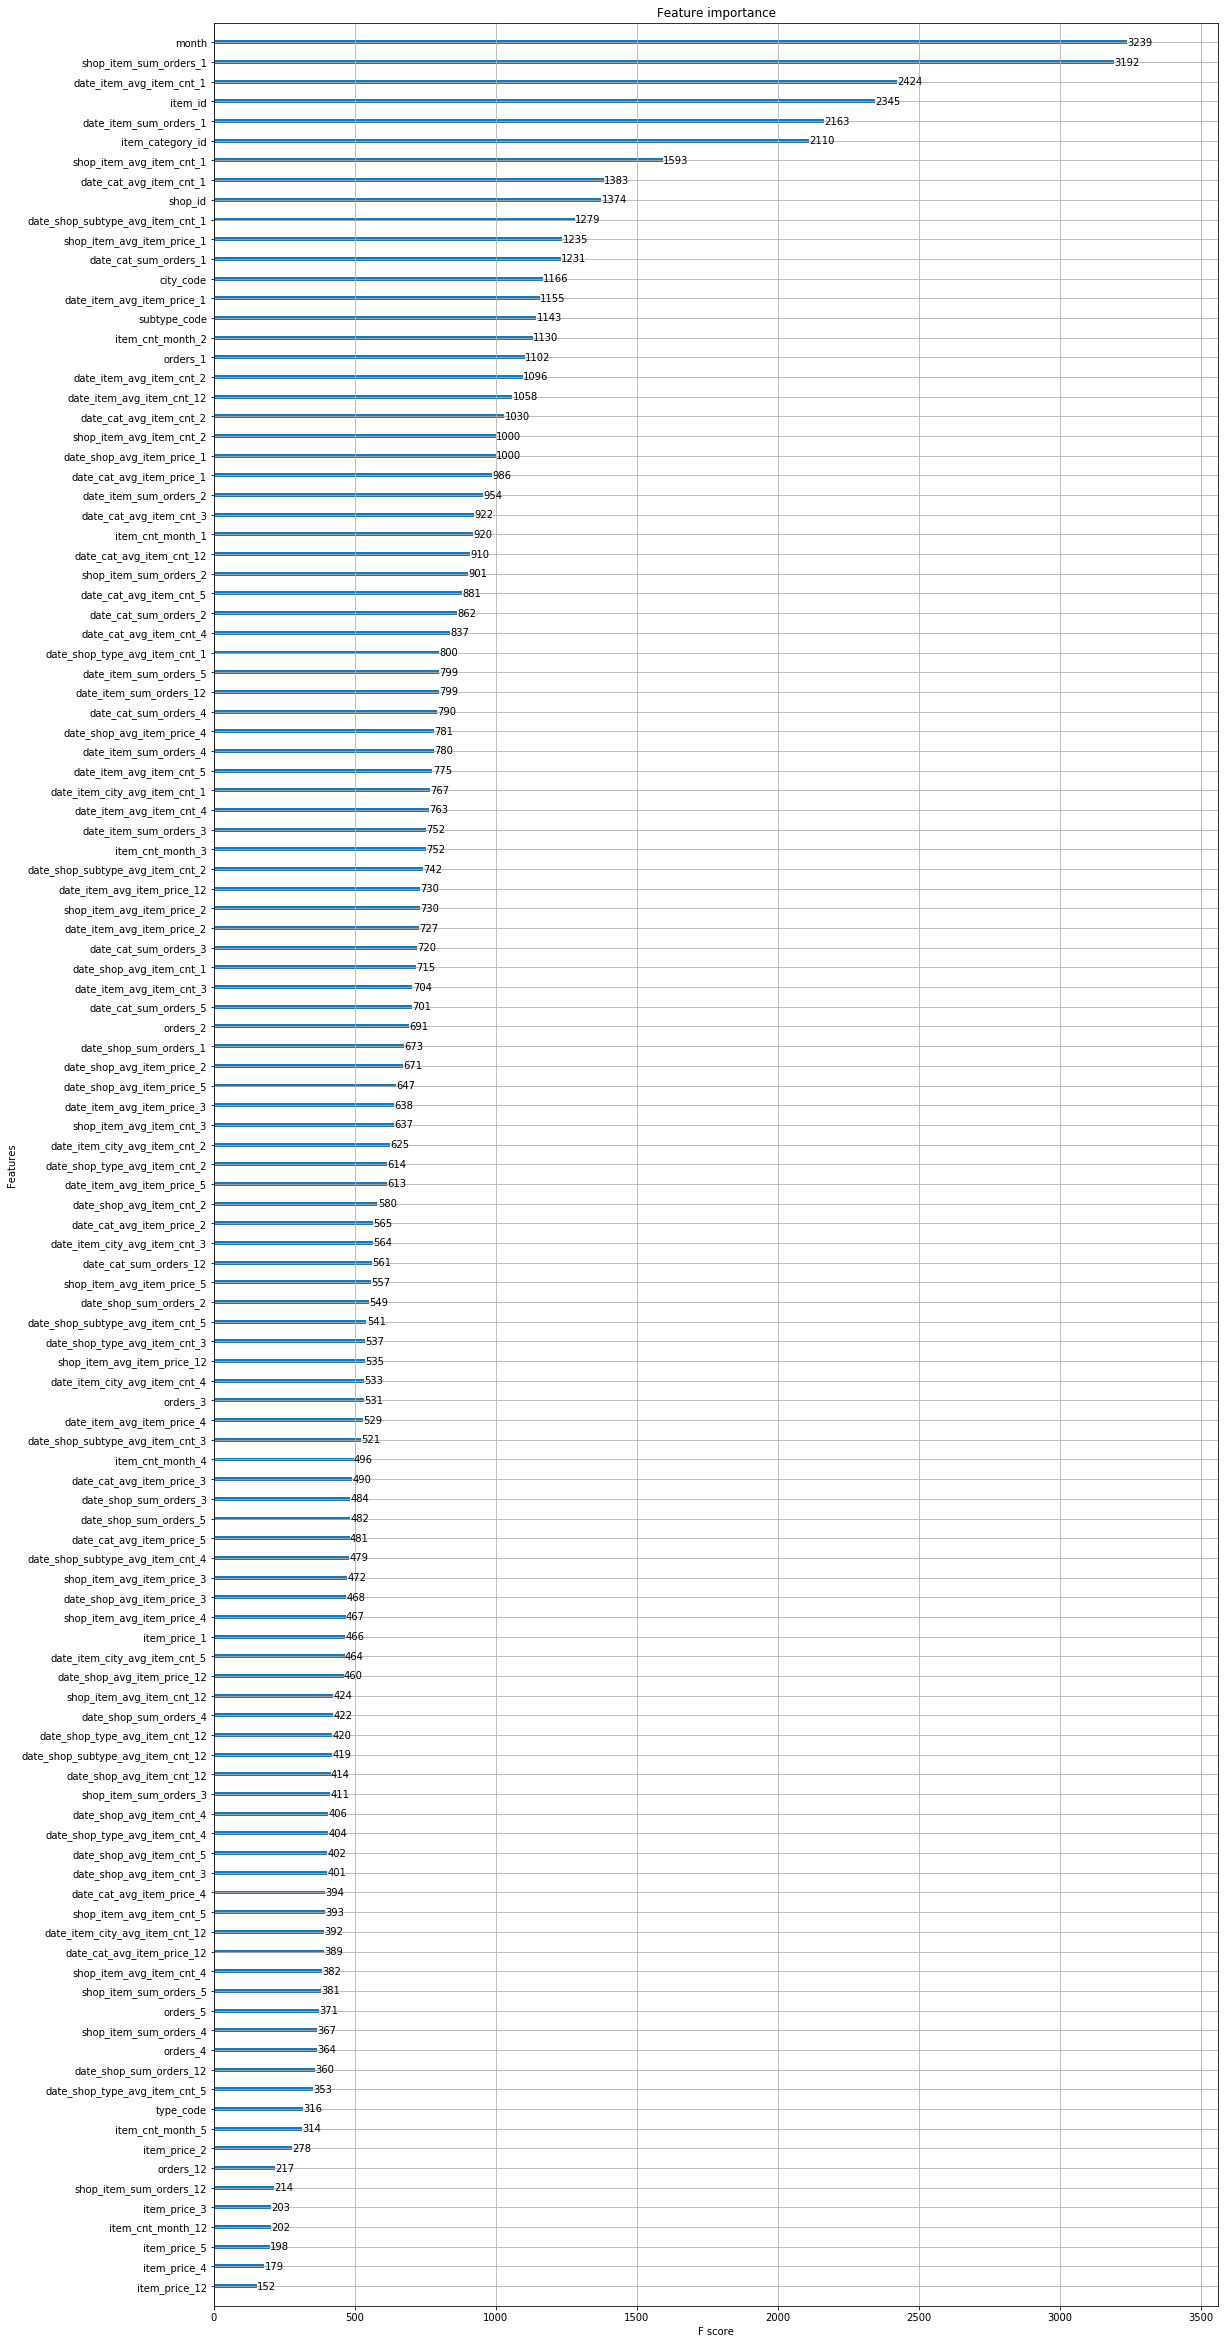

In [5]:
plot_features(m1, (18,42))

In [6]:
Y_test = m1.predict(X_test).clip(0, 20)

test = pd.read_csv('test.csv.gz', compression='gzip').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)